In [35]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn

import re
import nltk 

from sklearn.feature_extraction.text import CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.model_selection import train_test_split
from time import time

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
#import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


#from google.colab import files
from matplotlib import pyplot as plt
import pandas as pd
import io
from sklearn.metrics import classification_report
import pickle

In [36]:
def performDataFrameManipulation():
  df = pd.read_csv('bullying_words.csv')

  for index in df.index:
    if df.loc[index,"label"]==-1:
      df.loc[index,"label"]=1

  return df

df=performDataFrameManipulation()
df.head(6)

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1
5,tony sidaway is obviously a fist fuck ee he...,1


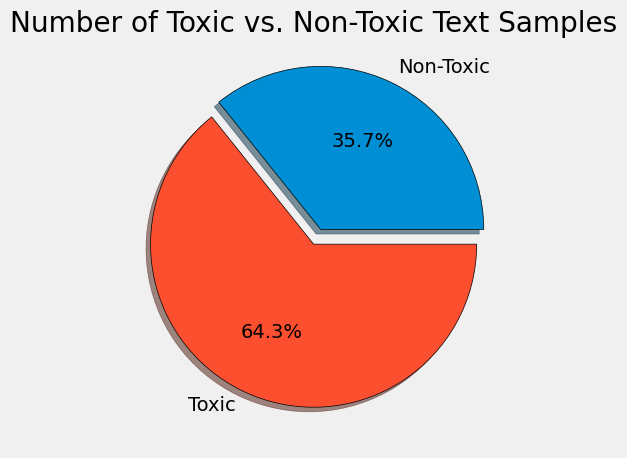

In [37]:
# Data classification using pie chart
def performDataDistribution(df):
  plt.style.use('fivethirtyeight')

  tot = df.shape[0]
  num_non_toxic = df[df.label==0].shape[0]
  slices = [num_non_toxic/tot,(tot - num_non_toxic)/tot]
  labeling = ['Non-Toxic','Toxic']
  explode = [0.1,0]
  plt.pie(slices,explode=explode,shadow=True,autopct='%1.1f%%',labels=labeling,wedgeprops={'edgecolor':'black'})
  plt.title('Number of Toxic vs. Non-Toxic Text Samples')
  plt.tight_layout()
  plt.show()

performDataDistribution(df)

In [38]:
#removing pattern
def remove_pattern(input_txt,pattern):
  if(type(input_txt)==str):
    r= re.findall(pattern,input_txt)
    for i in r:
      input_txt = re.sub(i,'',input_txt)
    return input_txt
  else:
    return ""

In [39]:
#import nltk
#nltk.download('omw-1.4')

def performDataSetCleaning(df):
  df['headline'].dtype
  df['length_headline'] = df['headline'].str.len()
  # combi = df.append(df,ignore_index=True)
  combi = pd.concat([df, df], ignore_index=True)
  # removes @user
  combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['headline'],"@[\w]*")
  # removes extra letters 
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-z#]"," ")
  # removes all those words with size less than 3 
  combi['tidy_tweet']= combi['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))

# calculate length of headline after cleaning
  combi['length_tidy_tweet'] = combi['tidy_tweet'].str.len()

  # Applied Tokenization
  tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) #creates a list

  # Applied Lemmatization 
  ##nltk.download('wordnet')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

  for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
  combi['tidy_tweet'] = tokenized_tweet

  return combi,df

combi,df=performDataSetCleaning(df)  
combi.head()

<>:10: SyntaxWarning: invalid escape sequence '\w'
<>:10: SyntaxWarning: invalid escape sequence '\w'
C:\Users\HP\AppData\Local\Temp\ipykernel_16300\2659799996.py:10: SyntaxWarning: invalid escape sequence '\w'
  combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['headline'],"@[\w]*")


,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


In [40]:
#Dataset splitting and applying feature extraction
def performTestDataSplitting(x,y,combi,df):
  X_train, X_test,y_train,y_test = train_test_split(combi['tidy_tweet'], 
                                                    combi['label'], 
                                                    test_size=x,random_state=y)
  print('Number of rows in the total set: {}'.format(combi.shape[0]))
  print('Number of rows in the training set: {}'.format(X_train.shape[0]))
  print('Number of rows in the test set: {}'.format(X_test.shape[0]))

  my_file = open("C:/Users/HP/Newproject/Chat_App/static/Dataset/stopwords.txt", "r")
  content = my_file.read()
  content_list = content.split("\n")
  my_file.close()

  # Instantiate the TfidfVectorizer method
  tfidf_vector = TfidfVectorizer(stop_words = content_list ,lowercase = True)

  # Fit the training data and then return the matrix
  training_data = tfidf_vector.fit_transform(X_train.values.astype('U'))
  print(X_train.shape)
  print(training_data.shape)

  # Transform testing data and return the matrix 
  testing_data = tfidf_vector.transform(X_test.values.astype('U'))

  filename = 'tfidf_vector_vocabulary.pkl'
  pickle.dump(tfidf_vector.vocabulary_, open(filename, 'wb'))

  return X_train,X_test,y_train,y_test,testing_data,filename,training_data,content_list

x_train,x_test,y_train,y_test,testing_data,filename,training_data,content_list = performTestDataSplitting(0.33,42,combi,df)

Number of rows in the total set: 36296
Number of rows in the training set: 24318
Number of rows in the test set: 11978


c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


(24318,)
(24318, 30256)


In [41]:
# Applying ML models
def pipeline(X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # make a list of models
    learner_list = [LinearSVC(),LogisticRegression()]
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []

    for learner in learner_list:
        
        print(learner)
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # making pickle file here for my various classifier

        filename = learner.__class__.__name__+".pkl"
        pickle.dump(learner, open(filename, 'wb'))


        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

final_results=pipeline(training_data,y_train,testing_data,y_test)

LinearSVC()
Training LinearSVC
Training LinearSVC finished in 0.14 sec
----------------------------------------------------
LogisticRegression()
Training LogisticRegression
Training LogisticRegression finished in 0.38 sec
----------------------------------------------------


In [42]:
def performFinalResults(final_results):
  results = pd.DataFrame(final_results)
  results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

  results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

  return results

results=performFinalResults(final_results)
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,LinearSVC,0.949157,0.963977,0.956584,0.960266,0.003553,0.989596,0.992631,0.991170,0.991900,0.143400
1,LogisticRegression,0.932710,0.952081,0.942675,0.947355,0.003033,0.962086,0.971832,0.969096,0.970462,0.383339


In [43]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.932710,0.952081,0.942675,0.947355,0.003033,0.962086,0.971832,0.969096,0.970462,0.143400
max,0.949157,0.963977,0.956584,0.960266,0.003553,0.989596,0.992631,0.991170,0.991900,0.383339


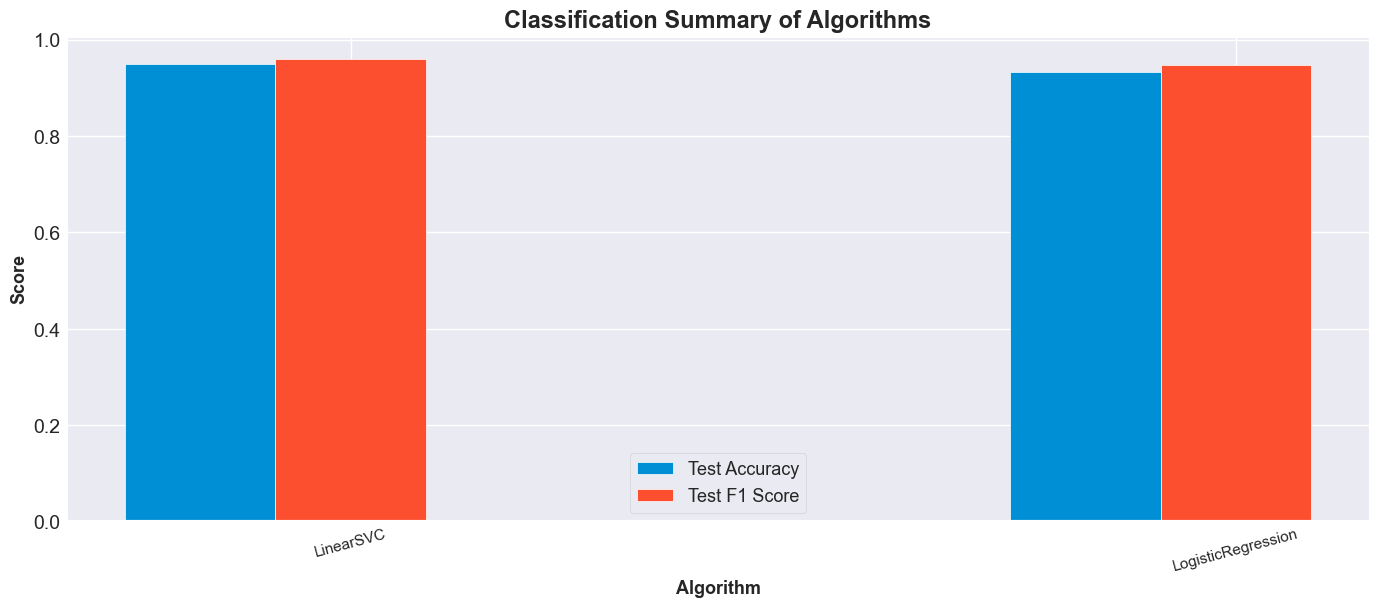

In [44]:
# Classification of Summary of Algorithma 
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

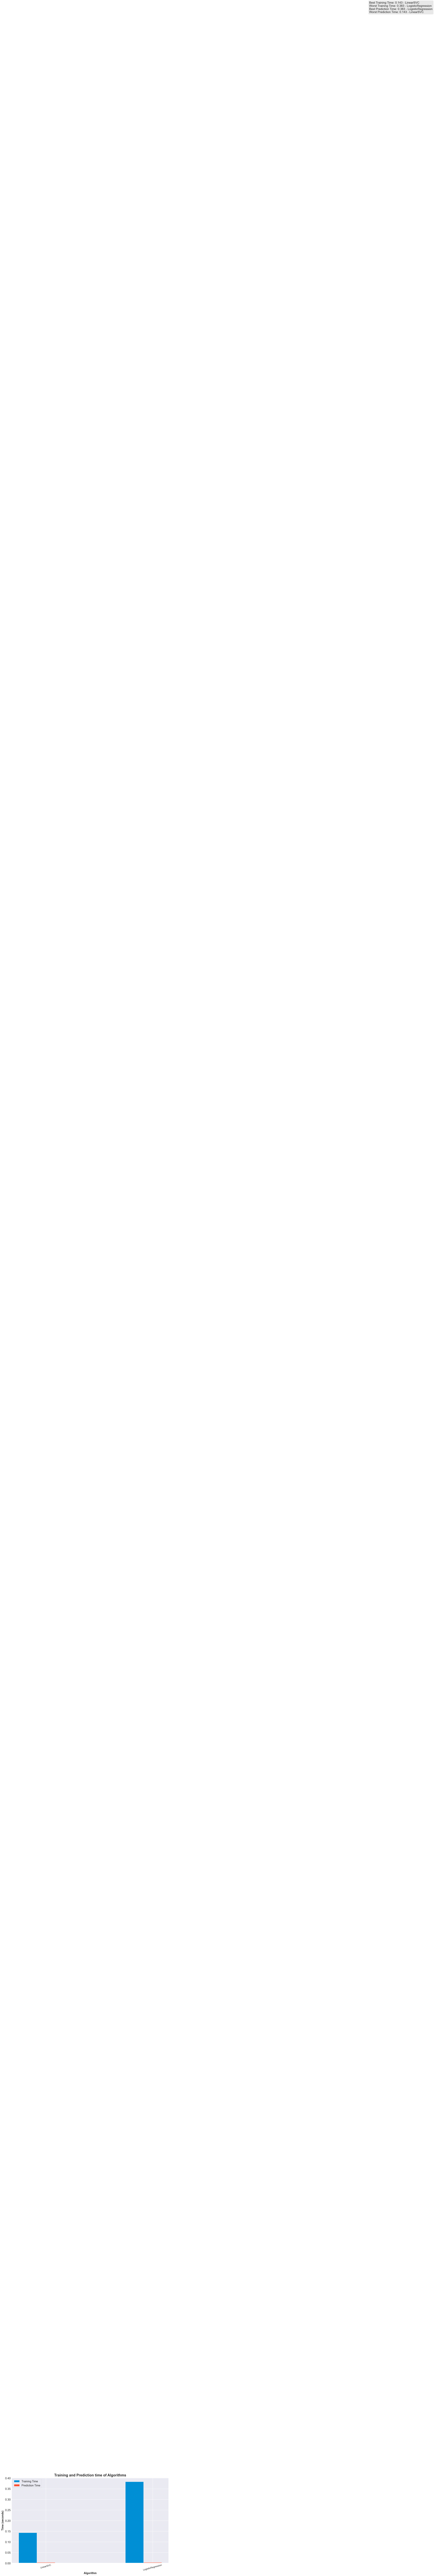

In [45]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [47]:
data = ["are you a moron"]
tfidf_vector = TfidfVectorizer(stop_words= content_list, lowercase = True,vocabulary=pickle.load(open("tfidf_vector_vocabulary.pkl", "rb")))
data= tfidf_vector.fit_transform(data)
print(data.shape)
trained_model=pickle.load(open("C:/Users/HP/Newproject/Chat_App/static/Dataset/LinearSVC.pkl", 'rb'))
print(trained_model.predict(data))
if(trained_model.predict(data)==1):
  print('bullying')
else:
  print('non-bullying')

(1, 30256)
[1]
bullying


In [ ]:
from sklearn.model_selection import GridSearchCV
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

In [ ]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)
pickle.dump(clf_linsvc, open('clf_svc_model.pkl', 'wb'))

LinearSVC

Optimized Model
------
Best Parameters: {'C': 1.2}
Accuracy: 0.9459
F1-score: 0.9578
Precision: 0.9606
Recall: 0.9549
